In [1]:
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image
from retinaface import RetinaFace
from timeit import default_timer as timer
import cv2
from pathlib import Path
import albumentations as A
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from facenet_pytorch import fixed_image_standardization
import torch

# Setting up for device agnostic code 

In [2]:
device="mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

# Defining helper function

In [3]:
data=['train','test']
def get_image(set):
    dPath=os.path.join("data",set)
    start=timer()
    data_set=os.listdir((dPath))
    file=[]
    for sample in data_set:
        if(sample[0]!="."):
            dPath=os.path.join("data",set)
            dPath=os.path.join(dPath,sample)
            images=os.listdir(dPath)
            for image in images:
                if(image[0]!="."):
                    dPath=os.path.join("data",set)
                    dPath=os.path.join(dPath,sample)
                    dPath=os.path.join(dPath,image)
                    file.append(dPath)
    file.sort(key= lambda p:(os.path.dirname(p),int('0'+ "".join(filter(str.isdigit,p.split(".")[0])))))
    return file
                
    end=timer()
test=get_image("test")
train=get_image("train")

# Functions for visualization of data

In [4]:
from math import ceil

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

from matplotlib.patches import Ellipse


def imshow(img, ax, title):
    ax.imshow(img)
    if title:
        el = Ellipse((2, -1), 0.5, 0.5)
        ax.annotate(title, xy=(1, 0), xycoords='axes fraction', ha='right', va='bottom',
                    bbox=dict(boxstyle="round", fc="0.8"),
                    arrowprops=dict(arrowstyle="simple", fc="0.6", ec="none",
                                    patchB=el, connectionstyle="arc3, rad=0.3"))
    ax.set_xticks([]), ax.set_yticks([])

def plot_gallery(images, ncols, nrows, titles=None, title='', figsize=None):
    if figsize is None:
        figsize = (18, ncols) if ncols < 10 else (18, 20)
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), axes_pad=0.02)

    for i, ax in enumerate(grid):
        if i == len(images): break
        imshow(images[i], ax, titles[i] if titles is not None else '')

    # there are some problems with suptitle alignment
    y_title_pos = grid[0].get_position().get_points()[1][1] - 0.33 / (1 if nrows == 1 else nrows / 3)
    plt.suptitle(title, y=y_title_pos, fontsize=12)

def plot(paths=None, images=None, titles=None, axtitle=True, title='', to_size=(512, 512)):
    """
    Plot image gallery by passing (paths, title) or (images, titles)
    :param paths: list of image paths
    :param images: list of (PIL.Image | np.array | torch.Tensor) objects
    :param titles: list of image titles
    :param bool axtitle: if paths is not None, then axtitle=True leads to use basedir name as titles
    :param str title: gallery title
    :param to_size: image resizing size before plot, default (512, 512)
    """

    if paths is not None and len(paths):
        images = [Image.open(p).resize(to_size) for p in paths]

        nrows = int(ceil(len(images) / 12)) # 12 images per row
        ncols = 12 if nrows > 1 else len(images)

        if axtitle:
              titles = [os.path.dirname(p).split('/')[-1] for p in paths]

        plot_gallery(images, ncols, nrows, titles, title)

    elif images is not None and len(images):
        if isinstance(images, list):
            images = np.array(images)

        nrows = int(ceil(len(images) / 12)) # 12 images per row
        ncols = 12 if nrows > 1 else len(images)

        # Rescale to [0., 1.]
        if images[0].max() > 1:
            images /= 255.

        # if torch.Tensor change axes
        if not isinstance(images, np.ndarray):
            if images.size(1) == 3 or 1:
                images = images.permute((0, 2, 3, 1))

        plot_gallery(images, ncols, nrows, titles, title)


    else:
        raise LookupError('You didnt pass any path or image objects')
    plt.show()

## Adding data argumentation

In [18]:
standard_transform = transforms.Compose([
                                np.float32,
                                transforms.ToTensor(),
                                fixed_image_standardization,
                                transforms.Resize([224, 224],antialias=None )
])
arg_mask=A.Compose([
    A.HorizontalFlip(p=0.50),
    A.RandomContrast(limit=0.5, p=0.4),
    A.VerticalFlip(p=0.50),
    A.Rotate(50,p=0.5),
    A.OneOrOther(A.Downscale(scale_min=0.15,scale_max=0.25,p=0.6),A.Blur(p=0.4),p=0.8),
    A.Resize(150,100),  # Resize smaller images
    A.CenterCrop(height=150, width=100,p=0.9),
    A.HueSaturationValue(val_shift_limit=10, p=0.3),
    A.OneOf([
        A.Rotate(45, p=0.3),
        A.ElasticTransform(sigma=20, alpha_affine=20, border_mode=0, p=0.2)
        ], p=0.5) 
])
transform={
    'train':transforms.Compose([
                                transforms.Lambda(lambda x: arg_mask(image=np.array(x))["image"]),
                                standard_transform]),
    'test':standard_transform
     }


# Adding data loader

In [19]:
trainData=datasets.ImageFolder("data/train",transform=standard_transform)
trainData_arg=datasets.ImageFolder("data/train",transform=transform["train"])
trainData_loader=DataLoader(trainData,batch_size=32)
trainDataArg_loader=DataLoader(trainData_arg,batch_size=32)
testData=datasets.ImageFolder("data/test",transform=standard_transform)
testData_loader=DataLoader(testData,batch_size=32)
CLASS_TO_IDX = dict(trainData.class_to_idx.items())


In [20]:
ClassList=trainData.class_to_idx
import pickle
with open('data/class_list.pkl', 'wb') as file:
    pickle.dump(ClassList, file)

In [21]:
import pickle
with open('data/class_list.pkl', 'rb') as file:
    ClassList = pickle.load(file)
def name_from_index(i,ClassList=ClassList):
    for name in ClassList:
        if ClassList[name]==i:
            return name
    return none
len(ClassList)

19

# Preparing the model

In [22]:
from facenet_pytorch import InceptionResnetV1
# from using_VGG import VGGnet
model = InceptionResnetV1(pretrained='vggface2', dropout_prob=0.5, device=device).eval()
# model = VGGnet(in_channels=3, num_classes=len(ClassList)).to(device)
model

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [23]:
import tqdm
import torch
def fixed_denormalize(image):
    """ Restandartize images to [0, 255]"""
    return image * 128 + 127.5
def get_embeds(model,loader,n,imshow=False,n_image=5):
    images=[]
    embeding=[]
    labels=[]
    for j in tqdm.trange(n):
        for i,(x,label) in enumerate(tqdm.auto.tqdm(loader),1):
            if imshow and i==1:
                inds=np.random.choice(x.size(0),min(x.size(0),n_image))
                images.append(fixed_denormalize(x[inds].data.cpu()).permute((0, 2, 3, 1)).numpy())
            embed=model(x.to(device))
            embed=embed.data.cpu().numpy()
            embeding.append(embed),labels.extend(label.data.cpu().numpy())
    if imshow:
        plot(images=np.concatenate(images))
    return np.concatenate(embeding), np.array(labels)

  0%|                                                     | 0/1 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:29<00:00, 29.41s/it]


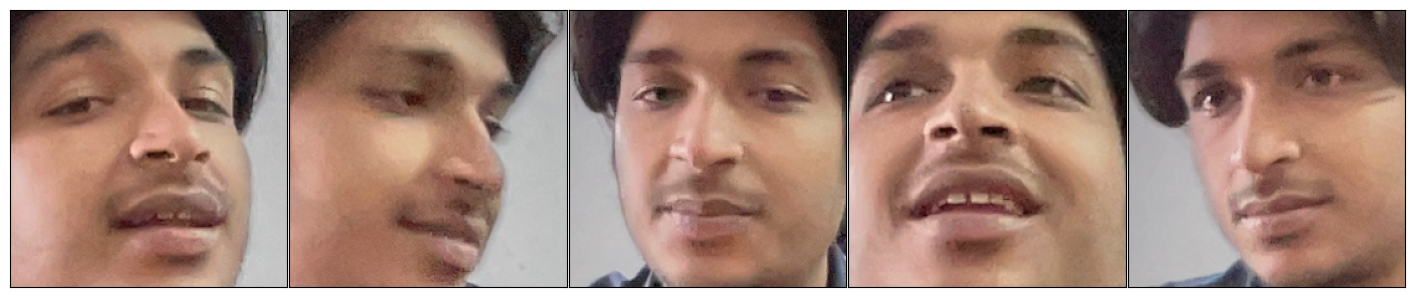

train Done here


  0%|                                                    | 0/60 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  2%|▋                                           | 1/60 [00:22<22:31, 22.91s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

  3%|█▍                                          | 2/60 [00:44<21:33, 22.31s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

  5%|██▏                                         | 3/60 [01:04<20:04, 21.13s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

  7%|██▉                                         | 4/60 [01:24<19:17, 20.67s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

  8%|███▋                                        | 5/60 [01:45<19:04, 20.82s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 10%|████▍                                       | 6/60 [02:07<19:10, 21.30s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 12%|█████▏                                      | 7/60 [02:28<18:36, 21.07s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 13%|█████▊                                      | 8/60 [02:48<18:03, 20.84s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 15%|██████▌                                     | 9/60 [03:09<17:42, 20.83s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 17%|███████▏                                   | 10/60 [03:31<17:33, 21.07s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 18%|███████▉                                   | 11/60 [03:52<17:09, 21.01s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 20%|████████▌                                  | 12/60 [04:13<17:00, 21.26s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 22%|█████████▎                                 | 13/60 [04:34<16:24, 20.95s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 23%|██████████                                 | 14/60 [04:51<15:13, 19.85s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 25%|██████████▊                                | 15/60 [05:05<13:34, 18.10s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 27%|███████████▍                               | 16/60 [05:17<11:53, 16.21s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 28%|████████████▏                              | 17/60 [05:29<10:39, 14.87s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 30%|████████████▉                              | 18/60 [05:40<09:36, 13.74s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 32%|█████████████▌                             | 19/60 [05:51<08:54, 13.05s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 33%|██████████████▎                            | 20/60 [06:02<08:17, 12.44s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 35%|███████████████                            | 21/60 [06:13<07:50, 12.06s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 37%|███████████████▊                           | 22/60 [06:24<07:27, 11.77s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 38%|████████████████▍                          | 23/60 [06:35<07:07, 11.54s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 40%|█████████████████▏                         | 24/60 [06:46<06:48, 11.35s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 42%|█████████████████▉                         | 25/60 [06:57<06:32, 11.21s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 43%|██████████████████▋                        | 26/60 [07:08<06:18, 11.13s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 45%|███████████████████▎                       | 27/60 [07:19<06:05, 11.07s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 47%|████████████████████                       | 28/60 [07:30<05:53, 11.04s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 48%|████████████████████▊                      | 29/60 [07:41<05:40, 10.99s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 50%|█████████████████████▌                     | 30/60 [07:52<05:28, 10.95s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 52%|██████████████████████▏                    | 31/60 [08:03<05:17, 10.94s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 53%|██████████████████████▉                    | 32/60 [08:14<05:06, 10.94s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 55%|███████████████████████▋                   | 33/60 [08:24<04:55, 10.93s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 57%|████████████████████████▎                  | 34/60 [08:35<04:42, 10.88s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 58%|█████████████████████████                  | 35/60 [08:46<04:30, 10.83s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 60%|█████████████████████████▊                 | 36/60 [08:57<04:19, 10.80s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 62%|██████████████████████████▌                | 37/60 [09:07<04:07, 10.76s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 63%|███████████████████████████▏               | 38/60 [09:18<03:55, 10.72s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 65%|███████████████████████████▉               | 39/60 [09:29<03:44, 10.69s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 67%|████████████████████████████▋              | 40/60 [09:39<03:33, 10.66s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 68%|█████████████████████████████▍             | 41/60 [09:50<03:23, 10.69s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 70%|██████████████████████████████             | 42/60 [10:01<03:12, 10.69s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 72%|██████████████████████████████▊            | 43/60 [10:11<03:01, 10.68s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 73%|███████████████████████████████▌           | 44/60 [10:22<02:50, 10.68s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 75%|████████████████████████████████▎          | 45/60 [10:33<02:39, 10.63s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 77%|████████████████████████████████▉          | 46/60 [10:43<02:28, 10.62s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 78%|█████████████████████████████████▋         | 47/60 [10:54<02:18, 10.62s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 80%|██████████████████████████████████▍        | 48/60 [11:04<02:07, 10.61s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 82%|███████████████████████████████████        | 49/60 [11:15<01:57, 10.65s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 83%|███████████████████████████████████▊       | 50/60 [11:26<01:46, 10.64s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 85%|████████████████████████████████████▌      | 51/60 [11:36<01:35, 10.63s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 87%|█████████████████████████████████████▎     | 52/60 [11:47<01:24, 10.61s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 88%|█████████████████████████████████████▉     | 53/60 [11:57<01:14, 10.62s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 90%|██████████████████████████████████████▋    | 54/60 [12:08<01:03, 10.65s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 92%|███████████████████████████████████████▍   | 55/60 [12:19<00:53, 10.66s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 93%|████████████████████████████████████████▏  | 56/60 [12:30<00:42, 10.66s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 95%|████████████████████████████████████████▊  | 57/60 [12:40<00:32, 10.68s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 97%|█████████████████████████████████████████▌ | 58/60 [12:51<00:21, 10.69s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

 98%|██████████████████████████████████████████▎| 59/60 [13:02<00:10, 10.69s/it]

  0%|          | 0/29 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 60/60 [13:12<00:00, 13.21s/it]


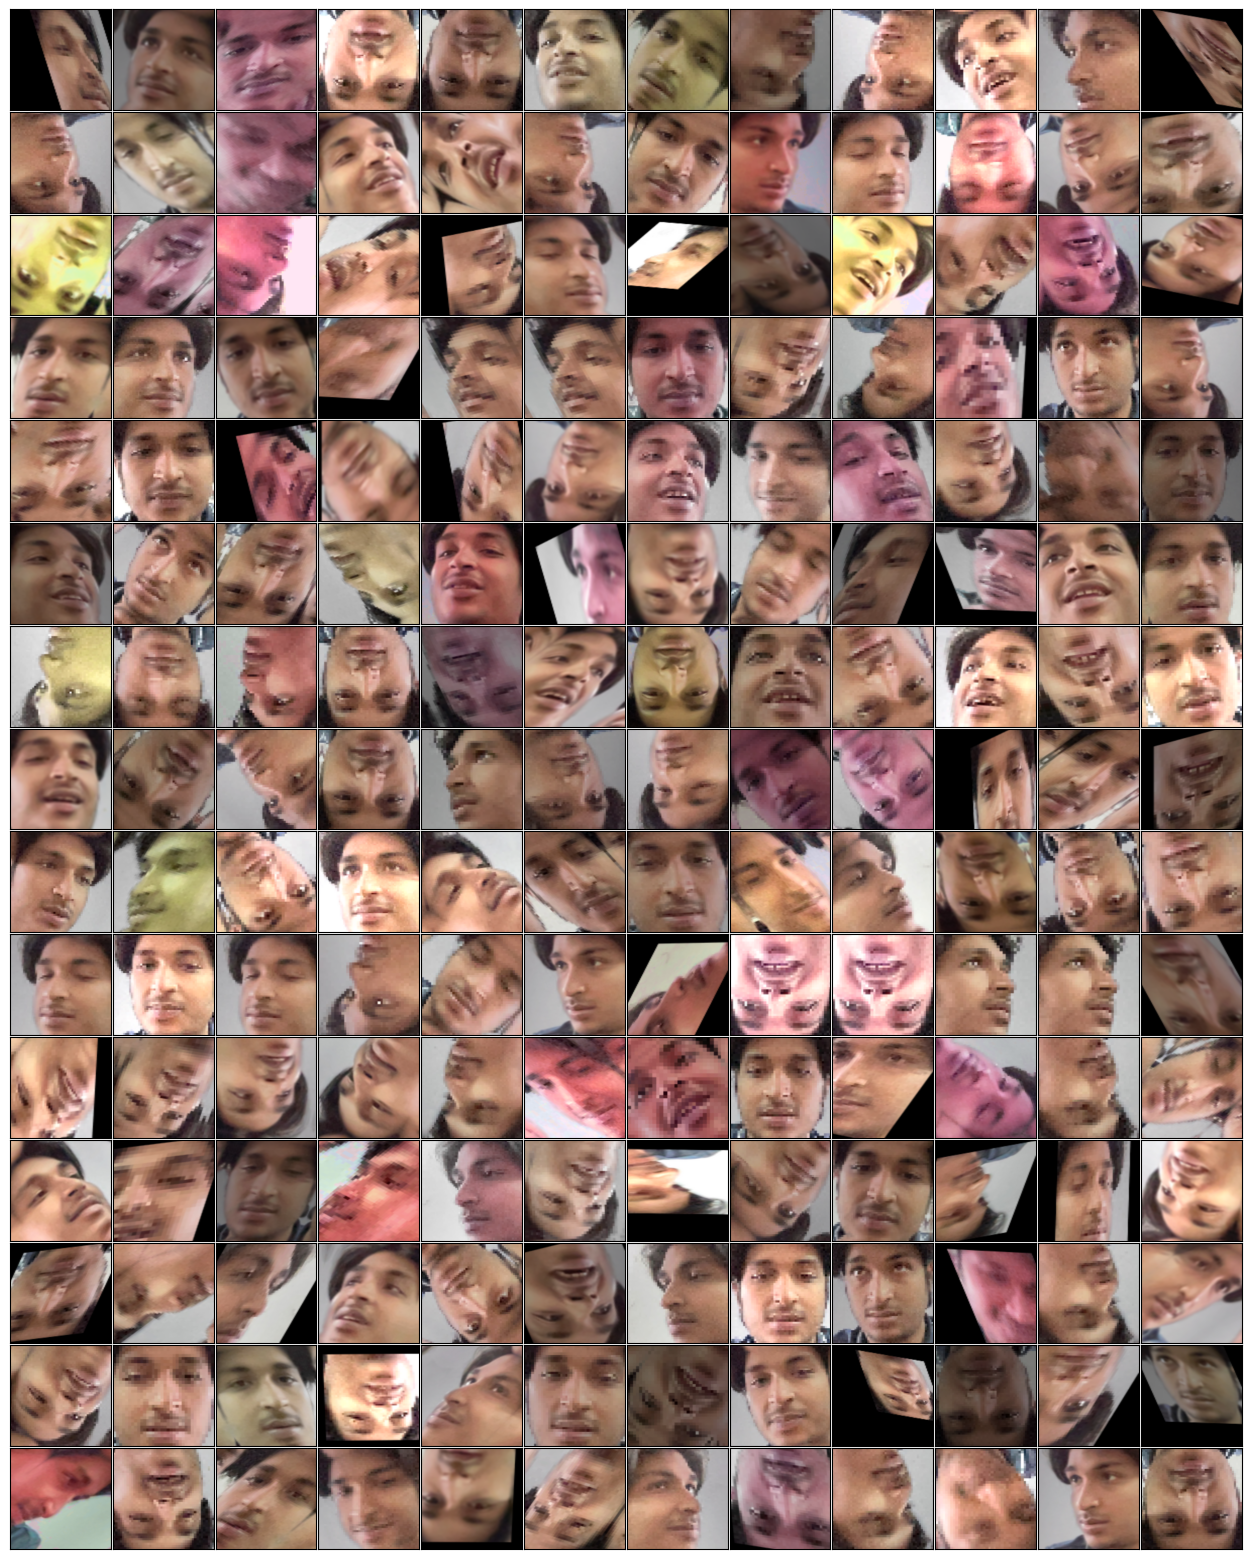

  0%|                                                     | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/it]


In [26]:
trainEmbeds, trainLabels = get_embeds(model,trainData_loader,1, True)
print("train Done here")
n=60
trainEmbeds_aug, trainLabels_aug = get_embeds(model,trainDataArg_loader,n,True, n_image=3)
testEmbeds,testLabels=get_embeds(model,testData_loader,1,False)

In [27]:
trainEmbeds=np.concatenate([trainEmbeds,trainEmbeds_aug])

trainLabels = np.concatenate([trainLabels, trainLabels_aug])


In [28]:
trainEmbeds.shape

(55144, 512)

In [29]:
from pathlib import Path
Embed_path=Path(f"data/Embedings/Embeding-{n}")
Embed_path.mkdir(parents=True, exist_ok=True)
TRAIN_EMBEDS = os.path.join(f"data/Embedings/Embeding-{n}", f'trainEmbeds{n}.npz')
TEST_EMBEDS = os.path.join(f"data/Embedings/Embeding-{n}", f'testEmbeds{n}.npz')

In [30]:
np.savez(TRAIN_EMBEDS, x=trainEmbeds, y=trainLabels)
np.savez(TEST_EMBEDS, x=testEmbeds, y=testLabels)

In [16]:
trainEmbeds, trainLabels = np.load(TRAIN_EMBEDS, allow_pickle=True).values()
testEmbeds, testLabels = np.load(TEST_EMBEDS, allow_pickle=True).values()

In [17]:
X_test, y_test = np.copy(testEmbeds), np.array([name_from_index(label) for label in testLabels])
print(f'X train embeds size: {X_test.shape}')
print(f'Tagret train size: {y_test.shape}')

X train embeds size: (282, 512)
Tagret train size: (282,)
